# Load dataframes

In [1]:
import warnings
import glob
import polars as pl
import matplotlib.pyplot as plt
# Suppress warnings
warnings.filterwarnings("ignore")

FREQ_MIN = 5
SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
DATA_DIR = "coinbase/5m"
MIN_OBS = 100

def load_symbol(sym: str, data_dir: str = DATA_DIR) -> pl.DataFrame | None:
    files = sorted(glob.glob(f"{data_dir}/*/{sym}_5m_*.csv"))
    if not files:
        return None
    df = pl.concat([
        pl.read_csv(f, has_header=False,
                    new_columns=['time', 'open', 'high', 'low', 'close', 'volume'],
                    schema={'time': pl.Int64, 'open': pl.Float64, 'high': pl.Float64,
                            'low': pl.Float64, 'close': pl.Float64, 'volume': pl.Float64})
        for f in files
    ])
    # Remove nulls and NaNs in 'close' after loading
    df = (df
          .filter(pl.col('close').is_not_null())
          .filter(~pl.col('close').is_nan())
          .with_columns(pl.from_epoch('time', time_unit='s').alias('datetime'))
          .sort('time')
          .unique('time', keep='first'))
    return df if df.height >= MIN_OBS else None

def align_time(df: pl.DataFrame) -> pl.DataFrame:
    min_t, max_t = df['time'].min(), df['time'].max()
    time_idx = pl.arange(min_t, max_t + 1, FREQ_MIN * 60, eager=True)
    base = pl.DataFrame({'time': time_idx})
    aligned = (base
               .join(df.select(['time', 'close']), on='time', how='left')
               .with_columns(pl.from_epoch('time', time_unit='s').alias('datetime'))
               .sort('time'))
    # Remove nulls and NaNs in 'close'
    aligned = aligned.filter(pl.col('close').is_not_null())
    aligned = aligned.filter(~pl.col('close').is_nan())
    # Keep only ['datetime', 'close']
    aligned = aligned.select(['datetime', 'close'])
    return aligned

def compute_spread(df1: pl.DataFrame, df2: pl.DataFrame, label1: str, label2: str) -> pl.DataFrame | None:
    if df1 is None or df2 is None:
        return None
    spread_df = df1.join(df2, on='datetime', how='inner', suffix='_' + label2)
    # Remove nulls and NaNs before calculation
    spread_df = spread_df.filter(
        pl.col('close').is_not_null() & pl.col(f'close_{label2}').is_not_null() &
        ~pl.col('close').is_nan() & ~pl.col(f'close_{label2}').is_nan()
    )
    if spread_df.height == 0:
        return None
    spread_df = spread_df.with_columns(
        (pl.col('close') - pl.col(f'close_{label2}')).alias(f'spread_{label1}_{label2}')
    )
    spread_col = f'spread_{label1}_{label2}'
    spread_df = spread_df.select(['datetime', spread_col])
    # Remove nulls and NaNs in spread column
    spread_df = spread_df.drop_nulls().drop_nans(subset=[spread_col])
    return spread_df

# Load and align symbols
BTCUSD_df = load_symbol('BTCUSD')
ETHUSD_df = load_symbol('ETHUSD')
SOLUSD_df = load_symbol('SOLUSD')
XRPUSD_df = load_symbol('XRPUSD')

BTCUSD_aligned = align_time(BTCUSD_df) if BTCUSD_df is not None else None
ETHUSD_aligned = align_time(ETHUSD_df) if ETHUSD_df is not None else None
SOLUSD_aligned = align_time(SOLUSD_df) if SOLUSD_df is not None else None
XRPUSD_aligned = align_time(XRPUSD_df) if XRPUSD_df is not None else None

for sym, df in zip(SYMBOLS, [BTCUSD_aligned, ETHUSD_aligned, SOLUSD_aligned, XRPUSD_aligned]):
    if df is not None:
        print(f"{sym}: {df.height} rows after alignment (no NaNs)")
    else:
        print(f"{sym}: No data loaded")



BTCUSD: 1011374 rows after alignment (no NaNs)
ETHUSD: 958887 rows after alignment (no NaNs)
SOLUSD: 438224 rows after alignment (no NaNs)
XRPUSD: 220518 rows after alignment (no NaNs)


# Create spread + spread of spread dataframes

In [2]:
from itertools import combinations

aligned_dfs = {
    'BTCUSD': BTCUSD_aligned,
    'ETHUSD': ETHUSD_aligned,
    'SOLUSD': SOLUSD_aligned,
    'XRPUSD': XRPUSD_aligned
}

spread_dfs = {}

for sym1, sym2 in combinations(SYMBOLS, 2):
    spread_df = compute_spread(aligned_dfs[sym1], aligned_dfs[sym2], sym1, sym2)
    if spread_df is not None and spread_df.height > 0:
        spread_dfs[f"{sym1}-{sym2}"] = spread_df
        print(f"Spread {sym1}-{sym2}: {spread_df.height} rows (no NaNs)")

spread_of_spread_dfs = {}

for (spread1, spread2) in combinations(spread_dfs.keys(), 2):
    df1 = spread_dfs[spread1]
    df2 = spread_dfs[spread2]
    sos_df = df1.join(df2, on='datetime', how='inner', suffix=f"_{spread2}")
    if sos_df.height == 0:
        continue

    col1 = f"spread_{spread1.replace('-', '_')}"
    col2 = f"spread_{spread2.replace('-', '_')}"

    sos_df = sos_df.with_columns(
        (pl.col(col1) - pl.col(col2)).alias(f"spread_of_spread_{spread1}_{spread2}")
    )

    spread_of_spread_col = f"spread_of_spread_{spread1}_{spread2}"
    sos_df = sos_df.select(['datetime', spread_of_spread_col])
    # Remove nulls and NaNs explicitly
    sos_df = sos_df.drop_nulls().drop_nans(subset=[spread_of_spread_col])

    if sos_df.height > 0:
        spread_of_spread_dfs[f"{spread1} - {spread2}"] = sos_df
        print(f"Spread of Spread {spread1} - {spread2}: {sos_df.height} rows (no NaNs)")


Spread BTCUSD-ETHUSD: 958426 rows (no NaNs)
Spread BTCUSD-SOLUSD: 438204 rows (no NaNs)
Spread BTCUSD-XRPUSD: 220498 rows (no NaNs)
Spread ETHUSD-SOLUSD: 438197 rows (no NaNs)
Spread ETHUSD-XRPUSD: 220492 rows (no NaNs)
Spread SOLUSD-XRPUSD: 220518 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - BTCUSD-SOLUSD: 438196 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - BTCUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - ETHUSD-SOLUSD: 438196 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - ETHUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - SOLUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-SOLUSD - BTCUSD-XRPUSD: 220498 rows (no NaNs)
Spread of Spread BTCUSD-SOLUSD - ETHUSD-SOLUSD: 438196 rows (no NaNs)
Spread of Spread BTCUSD-SOLUSD - ETHUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-SOLUSD - SOLUSD-XRPUSD: 220498 rows (no NaNs)
Spread of Spread BTCUSD-XRPUSD - ETHUSD-SOLUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-XRPUSD - ETH

# Pull VIX & Liquidity (WALCL from FRED) and merge with the spread dfs

In [3]:
from itertools import combinations
from yahooquery import Ticker
from fredapi import Fred

# --- GET VIX DATA ---
def get_yahoo_adjclose(ticker: str, start="2000-01-01", end=None) -> pl.DataFrame:
    t = Ticker(ticker)
    hist = t.history(start=start, end=end, interval='1d')
    if hist is None or hist.empty:
        return pl.DataFrame()
    hist = hist.reset_index()
    df = pl.from_pandas(hist)
    return df.select(["date", "adjclose"]).rename({"adjclose": "vix"}).with_columns(
        pl.col("date").cast(pl.Date)  # ✅ Ensure date type is pl.Date
    )

vix_data = get_yahoo_adjclose('^VIX')
print("VIX adjclose data head:")
print(vix_data.head())

# --- GET WALCL (FED BALANCE SHEET) DATA ---
FRED_API_KEY = r"03475c605a2572a0af9e16f56ba2f0f2"
fred = Fred(api_key=FRED_API_KEY)
liquidity_data = fred.get_series('WALCL', observation_start='2008-01-01')

liquidity_df = pl.DataFrame({
    "date": liquidity_data.index,
    "liquidity": liquidity_data.values  # ✅ Rename column here
}).with_columns(
    pl.col("date").cast(pl.Date)  # ✅ Ensure date type is pl.Date
)

# --- ALIGN MACRO DATA TO 5-MIN BARS ---
# Get reference 5-min datetime index from any aligned crypto dataframe
reference_dt = aligned_dfs['BTCUSD'].select('datetime')

# Join VIX
vix_aligned = reference_dt.with_columns([
    pl.col("datetime").cast(pl.Date).alias("date")
]).join(vix_data, on="date", how="left").sort("datetime").fill_null(strategy="forward")

# Join Liquidity
liquidity_aligned = reference_dt.with_columns([
    pl.col("datetime").cast(pl.Date).alias("date")
]).join(liquidity_df, on="date", how="left").sort("datetime").fill_null(strategy="forward")

# Drop intermediate 'date' columns
vix_aligned = vix_aligned.drop("date")
liquidity_aligned = liquidity_aligned.drop("date")

# --- COMPUTE SPREADS ---
spread_dfs = {}
SYMBOLS = list(aligned_dfs.keys())

for sym1, sym2 in combinations(SYMBOLS, 2):
    spread_df = compute_spread(aligned_dfs[sym1], aligned_dfs[sym2], sym1, sym2)
    if spread_df is not None and spread_df.height > 0:
        # Add macro data
        spread_df = spread_df.join(vix_aligned, on='datetime', how='left')
        spread_df = spread_df.join(liquidity_aligned, on='datetime', how='left')
        spread_df = spread_df.drop_nulls()
        spread_dfs[f"{sym1}-{sym2}"] = spread_df
        print(f"Spread {sym1}-{sym2}: {spread_df.height} rows (no NaNs)")

# --- COMPUTE SPREAD-OF-SPREADS ---
spread_of_spread_dfs = {}

for (spread1, spread2) in combinations(spread_dfs.keys(), 2):
    df1 = spread_dfs[spread1]
    df2 = spread_dfs[spread2]
    sos_df = df1.join(df2, on='datetime', how='inner', suffix=f"_{spread2}")
    if sos_df.height == 0:
        continue

    col1 = f"spread_{spread1.replace('-', '_')}"
    col2 = f"spread_{spread2.replace('-', '_')}"
    sos_col = f"spread_of_spread_{spread1}_{spread2}"

    sos_df = sos_df.with_columns(
        (pl.col(col1) - pl.col(col2)).alias(sos_col)
    )

    # Keep datetime, macro vars, and new SoS column
    sos_df = sos_df.select([
        'datetime',
        sos_col,
        'vix',
        'liquidity'  # ✅ Updated column name
    ]).drop_nulls()

    if sos_df.height > 0:
        spread_of_spread_dfs[f"{spread1} - {spread2}"] = sos_df
        print(f"Spread of Spread {spread1} - {spread2}: {sos_df.height} rows (no NaNs)")


VIX adjclose data head:
shape: (5, 2)
┌────────────┬───────────┐
│ date       ┆ vix       │
│ ---        ┆ ---       │
│ date       ┆ f64       │
╞════════════╪═══════════╡
│ 2000-01-03 ┆ 24.209999 │
│ 2000-01-04 ┆ 27.01     │
│ 2000-01-05 ┆ 26.41     │
│ 2000-01-06 ┆ 25.73     │
│ 2000-01-07 ┆ 21.719999 │
└────────────┴───────────┘
Spread BTCUSD-ETHUSD: 958426 rows (no NaNs)
Spread BTCUSD-SOLUSD: 438204 rows (no NaNs)
Spread BTCUSD-XRPUSD: 220498 rows (no NaNs)
Spread ETHUSD-SOLUSD: 438196 rows (no NaNs)
Spread ETHUSD-XRPUSD: 220491 rows (no NaNs)
Spread SOLUSD-XRPUSD: 220498 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - BTCUSD-SOLUSD: 438196 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - BTCUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - ETHUSD-SOLUSD: 438196 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - ETHUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-ETHUSD - SOLUSD-XRPUSD: 220491 rows (no NaNs)
Spread of Spread BTCUSD-SOLUSD - BTCUSD-XRPUSD: 220

In [4]:
spread_dfs['BTCUSD-ETHUSD']

datetime,spread_BTCUSD_ETHUSD,vix,liquidity
datetime[μs],f64,f64,f64
2016-05-23 14:15:00,429.18,15.82,4.473741e6
2016-05-23 22:10:00,430.66,15.82,4.473741e6
2016-05-23 23:50:00,432.38,15.82,4.473741e6
2016-05-24 00:15:00,432.36,14.42,4.473741e6
2016-05-24 07:50:00,433.19,14.42,4.473741e6
…,…,…,…
2025-08-17 15:00:00,113664.48,15.09,6.643615e6
2025-08-17 15:05:00,113683.18,15.09,6.643615e6
2025-08-17 15:10:00,113740.13,15.09,6.643615e6


Correlation between 5-min spread % change and VIX daily % change (forward filled): -0.010
Correlation between 5-min spread % change and liquidity daily % change (forward filled): 0.001


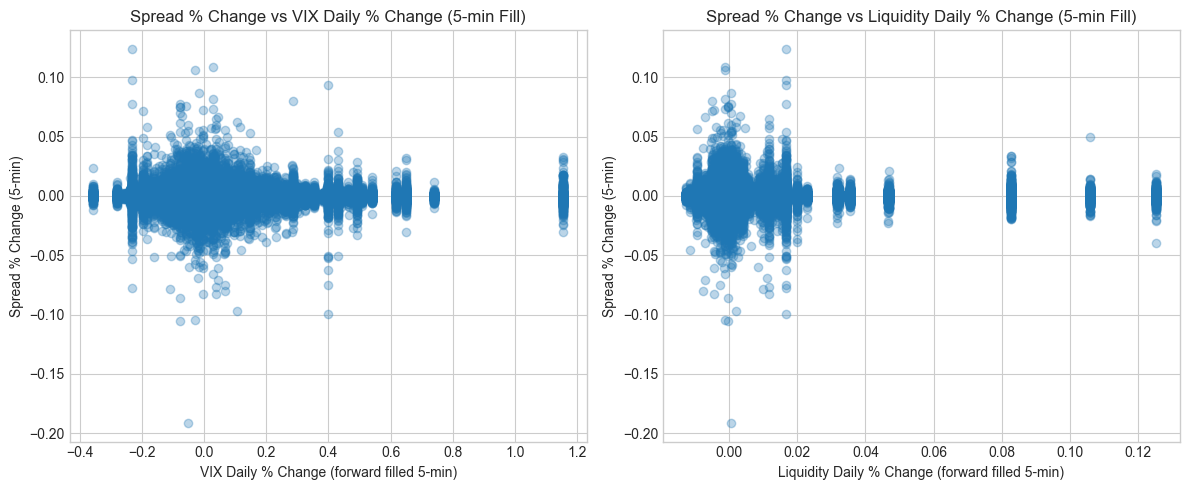

In [22]:
import polars as pl
import matplotlib.pyplot as plt

# Calculate VIX and Liquidity daily % changes
vix_pct = (
    vix_data
    .sort("date")
    .with_columns(pl.col("vix").pct_change().alias("vix_pct_change"))
    .select(["date", "vix_pct_change"])
    .drop_nulls()
)

liq_pct = (
    liquidity_df
    .sort("date")
    .with_columns(pl.col("liquidity").pct_change().alias("liq_pct_change"))
    .select(["date", "liq_pct_change"])
    .drop_nulls()
)

# Create 5-min time index to cover spread_df timestamps
spread_df = spread_dfs['BTCUSD-ETHUSD']

time_idx = pl.DataFrame({
    "datetime": pl.datetime_range(
        start=spread_df["datetime"].min(),
        end=spread_df["datetime"].max(),
        interval="5m",
        eager=True
    )
}).with_columns(pl.col("datetime").cast(pl.Date).alias("date"))



# Upsample daily VIX and liquidity to 5-min by joining on date and forward filling
vix_pct_5min = (
    time_idx.join(vix_pct, on="date", how="left")
    .sort("datetime")
    .with_columns(pl.col("vix_pct_change").forward_fill())
    .select(["datetime", "vix_pct_change"])
)

liq_pct_5min = (
    time_idx.join(liq_pct, on="date", how="left")
    .sort("datetime")
    .with_columns(pl.col("liq_pct_change").forward_fill())
    .select(["datetime", "liq_pct_change"])
)

# Merge VIX and liquidity 5-min pct changes directly into spread_df (5-min freq)
merged = (
    spread_df
    .join(vix_pct_5min, on="datetime", how="left")
    .join(liq_pct_5min, on="datetime", how="left")
).drop_nulls()

# Calculate spread percentage change on spread_df directly (5-min percentage change)
merged = merged.with_columns(
    pl.col("spread_BTCUSD_ETHUSD").pct_change().alias("spread_pct_change")
).drop_nulls()

# Calculate correlations
corr_vix = merged.select(pl.corr("spread_pct_change", "vix_pct_change")).to_series()[0]
corr_liq = merged.select(pl.corr("spread_pct_change", "liq_pct_change")).to_series()[0]

print(f"Correlation between 5-min spread % change and VIX daily % change (forward filled): {corr_vix:.3f}")
print(f"Correlation between 5-min spread % change and liquidity daily % change (forward filled): {corr_liq:.3f}")

# Plot correlations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(merged["vix_pct_change"], merged["spread_pct_change"], alpha=0.3)
plt.title("Spread % Change vs VIX Daily % Change (5-min Fill)")
plt.xlabel("VIX Daily % Change (forward filled 5-min)")
plt.ylabel("Spread % Change (5-min)")

plt.subplot(1, 2, 2)
plt.scatter(merged["liq_pct_change"], merged["spread_pct_change"], alpha=0.3)
plt.title("Spread % Change vs Liquidity Daily % Change (5-min Fill)")
plt.xlabel("Liquidity Daily % Change (forward filled 5-min)")
plt.ylabel("Spread % Change (5-min)")

plt.tight_layout()
plt.show()
